In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from flux_utils import flux_conversion
from astropy import units as u
from astropy import constants as const
import numpy as np
from data import aeff_ehe_gfu, aeff_ehe, aeff_hese
from plots import fontsize, fig_width
from blackbody import wiens_law

In [2]:
# Simple approximation scaling from TXS 0506+056

# x = [200 * 10**12, 10*10.**15]
x = [100 * 10**12, 10*10.**15]


e_integral = np.log(x[1]/x[0])

ul_txs_6_month_flux = 5. * 10 **-11. * u.erg / (u.cm**2 * u.s)
ul_txs_6_month = ul_txs_6_month_flux /(flux_conversion/u.cm**2)

fluence = ((1./(x[0] * (1*(u.eV).to("erg")))) * u.erg * ul_txs_6_month_flux * (0.5 * u.year).to("s")/(u.erg**2.))
a_eff_ehe = (1./fluence).to("m2")
print(f"Effective area (EHE): {a_eff_ehe:.2f}")

# print(((e_integral * u.eV) / (ul_txs_6_month_flux * (0.5 * u.year).to("s"))).to("m2"))

ratio_ehe_alert = (6.6 + 2.8) / 2.1 # ICRC REALTIME PAPER RATIO GOLD TO EHE
ul_6_month_alert = ul_txs_6_month / ratio_ehe_alert

a_eff_alert = a_eff_ehe * ratio_ehe_alert
print(f"Effective area (Alert): {a_eff_alert:.2f}")

Effective area (EHE): 20.31 m2
Effective area (Alert): 90.90 m2


In [3]:
print(ul_txs_6_month * flux_conversion * (0.5 * u.year).to("s"))

0.0007889399999999999 erg


In [4]:
print(ratio_ehe_alert)

4.476190476190475


In [5]:
print(ul_6_month_alert*(0.5 * u.year).to("s"))

1.1679870814766889e+51 erg


In [6]:
ul_e = ul_6_month_alert * (0.5 * u.year).to("s")

In [7]:
print(ul_e)

1.1679870814766889e+51 erg


Text(0.5, 1.0, 'IceCube Effective Area (-5$^{\\circ}$ < $\\delta$ < 30$^{\\circ}$)')

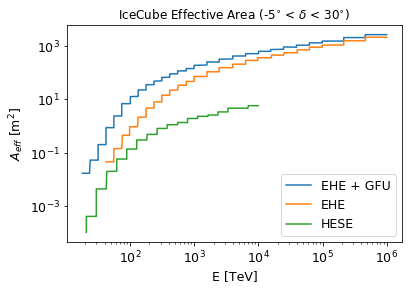

In [8]:
plt.figure(figsize=(fig_width, fig_width *2./3.))
ax = plt.subplot(111)
plt.plot(aeff_ehe_gfu["E_TeV"], aeff_ehe_gfu["A_eff"], label="EHE + GFU")
plt.plot(aeff_ehe["E_TeV"], aeff_ehe["A_eff"], label="EHE")
plt.plot(aeff_hese["E_TeV"], aeff_hese["A_eff"], label="HESE")
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$A_{eff}$ [m$^{2}$]", fontsize=fontsize)
plt.xlabel(r"E [TeV]", fontsize=fontsize)
plt.legend(fontsize=fontsize)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
plt.title(r"IceCube Effective Area (-5$^{\circ}$ < $\delta$ < 30$^{\circ}$)")

Text(0.5, 1.0, 'IceCube Effective Area (-5$^{\\circ}$ < $\\delta$ < 30$^{\\circ}$)')

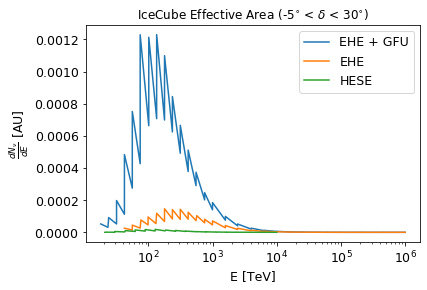

In [9]:
plt.figure(figsize=(fig_width, fig_width *2./3.))
ax = plt.subplot(111)
plt.plot(aeff_ehe_gfu["E_TeV"], aeff_ehe_gfu["A_eff"] * aeff_ehe_gfu["E_TeV"] **-2., label="EHE + GFU")
plt.plot(aeff_ehe["E_TeV"], aeff_ehe["A_eff"] * aeff_ehe["E_TeV"] **-2., label="EHE")
plt.plot(aeff_hese["E_TeV"], aeff_hese["A_eff"] * aeff_hese["E_TeV"] **-2. , label="HESE")
# plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$\frac{dN_{\nu}}{dE}$ [AU]", fontsize=fontsize)
plt.xlabel(r"E [TeV]", fontsize=fontsize)
plt.legend(fontsize=fontsize)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
plt.title(r"IceCube Effective Area (-5$^{\circ}$ < $\delta$ < 30$^{\circ}$)")

In [10]:
print(np.sum(aeff_ehe_gfu["A_eff"] * aeff_ehe_gfu["E_TeV"] **-2.))

0.014623465343435827


In [11]:
def integrate_aeff(aeff_df, power=2.0, e_min_gev=x[0]/(10.**9.), e_max_gev=x[1]/(10.**9.)):
    n_iter = int(len(aeff_df["E_TeV"])/int(2))

    a_eff = 0.
    
    for i in range(n_iter):
        lower = 2*i
        upper = 2*i + 1
        e_min = aeff_df["E_TeV"][lower] * 10**3
        e_max = aeff_df["E_TeV"][upper] * 10**3
        
        if np.logical_and(e_min > e_min_gev, e_min < e_max_gev):
        
            int_factor = (1./e_min**(power - 1.) - 1./e_max**(power - 1.)) * u.GeV
            aeff = np.mean([aeff_df["A_eff"][lower], aeff_df["A_eff"][upper]]) * u.m**2
            a_eff += int_factor * aeff
    
    return a_eff

In [12]:
power = 2.0

a_eff_vals = []
norms = []

int_energy = []

for i, aeff_df in enumerate([aeff_ehe_gfu, aeff_ehe, aeff_hese]):
    
    e_min_gev = x[0]/(10. ** 9.)
    e_max_gev = x[1]/(10. ** 9.)
    
    a_eff = integrate_aeff(aeff_df, power=power, e_min_gev=e_min_gev, e_max_gev=e_max_gev)

    norm_1gev = ((1.*u.GeV)**2./a_eff/(0.5*u.year)).to("erg cm^-2 s^-1")
    norm_100tev = norm_1gev * ((100 * u.TeV).to("GeV")/ u.GeV) ** -power
        
    norms.append(norm_1gev.to("GeV cm^-2 s^-1")/(1.* u.GeV**2))
    
    a_eff_vals.append(a_eff)
    
    if power == 2.0:
        int_factor = np.log(e_max_gev/e_min_gev)
        int_energy.append(int_factor)
    else:
        int_power = 2.0 - power
        int_factor = ((e_max ** int_power) - (e_min ** int_power))/(int_power)
        raise Exception("Integrate!")
        
    print(f"A flux normalisation of {norms[i]:.2g} is required for an expectation of one neutrino alert")
    print(f"A flux of {norm_1gev:.2g} at 1 GeV is required for an expectation of one neutrino alert")

print(f"Effective area increase EHE+GFU:EHE = {(a_eff_vals[0]/a_eff_vals[1]):.2f}")
print(r"This assumes an $E^{-" + str(f"{power:.2f}") + r"}$ Power Law")


A flux normalisation of 1e-08 1 / (cm2 GeV s) is required for an expectation of one neutrino alert
A flux of 1.7e-11 erg / (cm2 s) at 1 GeV is required for an expectation of one neutrino alert
A flux normalisation of 3.3e-08 1 / (cm2 GeV s) is required for an expectation of one neutrino alert
A flux of 5.2e-11 erg / (cm2 s) at 1 GeV is required for an expectation of one neutrino alert
A flux normalisation of 0.00012 1 / (cm2 GeV s) is required for an expectation of one neutrino alert
A flux of 1.9e-07 erg / (cm2 s) at 1 GeV is required for an expectation of one neutrino alert
Effective area increase EHE+GFU:EHE = 3.17
This assumes an $E^{-2.00}$ Power Law


In [13]:
flux_t = norms[0] * (0.5*u.year).to("s")
print(f"Required time-integrated flux normalisation for one alert: {flux_t:.2g} at 1GeV")
print(f"Required fluence for one alert: {(flux_t * (int_energy[0] * u.GeV**2.)):.2g}")
fluence_erg = (flux_t * (int_energy[0] * u.GeV**2.)).to("erg cm^-2")
print(f"Required fluence for one alert: {fluence_erg:.2g}")

en = (((int_energy[0] * u.GeV**2. * flux_t)/(flux_conversion / u.cm**2)).to("erg"))
print(f"Required energy for one alert: {en:.2g}")

Required time-integrated flux normalisation for one alert: 0.16 1 / (cm2 GeV) at 1GeV
Required fluence for one alert: 0.75 GeV / cm2
Required fluence for one alert: 0.0012 erg / cm2
Required energy for one alert: 8e+51 erg


In [14]:
def expected_energy(f_a=0.1, baryon_loading=100.):
    return 7.3 * 10**48. * u.erg * f_a**(-12./19.) * baryon_loading **(11./16.)

def n_exp(f_a=0.1, baryon_loading=100.):
    return (expected_energy(f_a, baryon_loading).to("GeV")/(int_energy[0] * u.GeV**2. * flux_t.to("GeV^-1 cm^-2")/(flux_conversion / u.cm**2) )).to("")

In [15]:
n_exp(baryon_loading=100.)

<Quantity 0.09297716>

In [16]:
def target_photons(e_nu, gamma=1.):
    e_p = 20. * e_nu.to("GeV")
    
    # For delta resonance:
    # E gamma E_p = gamma^2 0.5 GeV^2
    e_gamma = (gamma ** 2. * (0.16 * u.GeV ** 2.) / e_p).to("eV")
    
    # Planck's law
    nu = (e_gamma / const.h).to("Hz")
    wl = (const.c / nu).to("nm")
    
    print(f"Photon Energy is {e_gamma:.2g}")
    print(f"This corresponds to a frequency of {nu:.2g}, or a wavelength of {wl:.2g}")
    
    T = (e_gamma / (3. * const.k_B)).to("K")
    print(f"This corresponds to a temperature of {T:.2g}.")
    
    return e_gamma

def target_neutrino(t_gamma, gamma=1.):
    
    e_gamma = (3. * const.k_B * t_gamma).to("eV")
    
    print(f"Photon energy is {e_gamma:.2g}")
    
    frac_p = 1./20.
    
    # For delta resonance:
    # E gamma E_p = gamma^2 0.5 GeV^2
    e_p = (gamma ** 2. * (0.16 * u.GeV ** 2.) / e_gamma).to("eV")
    
    print(f"Proton Energy is {e_p:.2g}")
    
    e_nu = (frac_p * e_p).to("PeV")
    
    print(f"Neutrino Energy is {e_nu:.2g}")
    
    return e_nu

In [17]:
target_photons(0.2 * u.PeV)
target_photons(1.0 * u.PeV)
target_neutrino(10**5.8 * u.K)

Photon Energy is 40 eV
This corresponds to a frequency of 9.7e+15 Hz, or a wavelength of 31 nm
This corresponds to a temperature of 1.5e+05 K.
Photon Energy is 8 eV
This corresponds to a frequency of 1.9e+15 Hz, or a wavelength of 1.5e+02 nm
This corresponds to a temperature of 3.1e+04 K.
Photon energy is 1.6e+02 eV
Proton Energy is 9.8e+14 eV
Neutrino Energy is 0.049 PeV


<Quantity 0.04904512 PeV>

In [18]:
energy_level = ((1.232 * u.GeV)**2 - (0.938 * u.GeV)**2)/4
print(energy_level)
thresh = (0.05 * energy_level / const.k_B/3.).to("PeV K")
print(thresh)
print(thresh/ (10**5. * u.K))
print(thresh / (10**4.6 * u.K))

0.15949500000000005 GeV2
30847.710296610505 K PeV
0.30847710296610503 PeV
0.7748594493719436 PeV


In [19]:
print(0.3 * 10**0.4)

0.753565929452874


In [20]:
wiens_law(10**5.5)

<Quantity 9.16355952 nm>

In [21]:
def monoenergetic_threshold(e_nu):
    e_nu_tev = e_nu.to("TeV")
    bin_mask = aeff_ehe_gfu["E_TeV"] > e_nu_tev
    aeff = aeff_ehe_gfu[bin_mask].iloc[1]["A_eff"] * u.m**2
    number_flux = (1./aeff).to("cm^-2")
    fluence = number_flux * e_nu_tev.to("erg")
    print((fluence / (flux_conversion/ u.cm**2 )).to("erg"))
    return fluence

In [22]:
monoenergetic_threshold(1.0*u.PeV)

4.291117367311467e+51 erg


<Quantity 0.00064754 erg / cm2>

4.517642540094307e+51 erg
4.7392286106294637e+51 erg
4.96081468116462e+51 erg
5.182400751699777e+51 erg
3.896168928526867e+51 erg
4.055928156558513e+51 erg
4.2156873845901586e+51 erg
4.3754466126218035e+51 erg
4.53520584065345e+51 erg
4.694965068685096e+51 erg
4.8547242967167406e+51 erg
5.014483524748386e+51 erg
3.825597359975923e+51 erg
3.943715993018658e+51 erg
4.061834626061393e+51 erg
4.179953259104127e+51 erg
4.298071892146862e+51 erg
4.4161905251895975e+51 erg
4.534309158232331e+51 erg
4.652427791275067e+51 erg
4.770546424317802e+51 erg
4.888665057360537e+51 erg
3.892863818646736e+51 erg
3.984703167281156e+51 erg
4.076542515915576e+51 erg
4.168381864549996e+51 erg
4.260221213184416e+51 erg
4.352060561818836e+51 erg
4.4438999104532554e+51 erg
4.535739259087675e+51 erg
4.627578607722095e+51 erg
4.719417956356515e+51 erg
4.8112573049909345e+51 erg
4.903096653625355e+51 erg
4.994936002259775e+51 erg
5.0867753508941954e+51 erg
4.2343027419684593e+51 erg
4.3093953349313457e+51 erg
4.38

9.323794577160882e+51 erg
9.349242465217524e+51 erg
9.374690353274164e+51 erg
9.400138241330805e+51 erg
9.425586129387447e+51 erg
9.451034017444088e+51 erg
9.47648190550073e+51 erg
9.501929793557372e+51 erg
9.527377681614012e+51 erg
9.552825569670654e+51 erg
9.578273457727295e+51 erg
9.603721345783937e+51 erg
9.629169233840579e+51 erg
9.65461712189722e+51 erg
9.680065009953862e+51 erg
9.705512898010502e+51 erg
9.730960786067144e+51 erg
9.756408674123785e+51 erg
9.781856562180427e+51 erg
9.807304450237068e+51 erg
9.832752338293708e+51 erg
9.85820022635035e+51 erg
9.883648114406992e+51 erg
9.909096002463633e+51 erg
9.934543890520276e+51 erg
9.959991778576917e+51 erg
9.985439666633559e+51 erg
1.00108875546902e+52 erg
1.003633544274684e+52 erg
1.0061783330803481e+52 erg
1.0087231218860124e+52 erg
1.0112679106916765e+52 erg
1.0138126994973407e+52 erg
1.0163574883030046e+52 erg
1.0189022771086688e+52 erg
1.021447065914333e+52 erg
1.0239918547199974e+52 erg
1.0265366435256614e+52 erg
1.029081

1.6696636512299056e+52 erg
1.67136498043699e+52 erg
1.673066309644074e+52 erg
1.674767638851158e+52 erg
1.6764689680582425e+52 erg
1.6781702972653266e+52 erg
1.6798716264724103e+52 erg
1.6815729556794947e+52 erg
1.6832742848865792e+52 erg
1.6849756140936633e+52 erg
1.6866769433007476e+52 erg
1.688378272507832e+52 erg
1.6900796017149162e+52 erg
1.6917809309220002e+52 erg
1.6934822601290843e+52 erg
1.6951835893361688e+52 erg
1.6968849185432523e+52 erg
1.698586247750337e+52 erg
1.7002875769574212e+52 erg
1.7019889061645055e+52 erg
1.7036902353715893e+52 erg
1.7053915645786739e+52 erg
1.707092893785758e+52 erg
1.7087942229928422e+52 erg
1.7104955521999265e+52 erg
1.7121968814070106e+52 erg
1.713898210614095e+52 erg
1.715599539821179e+52 erg
1.7173008690282632e+52 erg
1.7190021982353475e+52 erg
1.7207035274424315e+52 erg
1.7224048566495159e+52 erg
1.7241061858566002e+52 erg
1.7258075150636842e+52 erg
1.7275088442707685e+52 erg
1.7292101734778528e+52 erg
1.730911502684937e+52 erg
1.732612831

Text(0.5, 0, '$E_{\\nu}$ [TeV]')

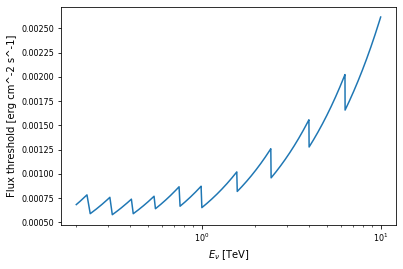

In [23]:
x = np.linspace(0.2, 10, 1000)
plt.plot(x, [monoenergetic_threshold(a*u.PeV).value for a in x])
plt.xscale("log")
plt.ylabel(r"Flux threshold [erg cm^-2 s^-1]")
plt.xlabel(r"$E_{\nu}$ [TeV]")

In [24]:
from scipy.stats import poisson
n_trials = 9.

In [25]:
def trial_correct(n_years, confidence=0.95):
    return confidence**(1./(n_years*n_trials))

In [26]:
thresh = trial_correct(7.)
print(thresh)

0.9991861520780205


In [27]:
poisson.cdf(1, mu=0.04)

0.9992210167184161

# Needed: Mathematical proof that this represents the most conservative distribution, i.e the one least likely to give a neutrino multiplet

In [28]:
cs = 5 * 10 ** -28 * u.cm**2
rbb = 10**14.5 * u.cm
mdelta = 1.232 * u.GeV
width = 150 * u.MeV/(mdelta)

def optical_depth(nu_hz, tk):
    
    nu = nu_hz * u.Hz
    t = tk * u.Kelvin
    
    e_photon = (const.h * nu)
    
    frac = e_photon/(const.k_B * t)
    
    dnu = nu
    
    # photon number density is mathematically equivalent to spectral energy density?
    
    sed = ((8 * np.pi * const.h * nu**3) * (1./(np.exp(frac) - 1.))/(const.c**3)).to("eV Hz^-1 cm^-3")
    print(f"Spectral Energy Density: {sed:.2g}")
    
    number_density = 0.1*nu * sed/e_photon.to("eV")
    
    print(f"Number Density: {number_density:.2g}")
    
    mfp = (1./(cs * number_density)).to("cm")
    
    print(f"Mean Free Path: {mfp:.2g}")
    print(f"Pion production efficiency: {1-np.exp(-rbb/mfp/5.):.2g}")
    
    return mfp

optical_depth(10**15, 10**4.6)

def optical_depth(e_nu_eV, tk):
    
#     nu = nu_hz * u.Hz
    t = tk * u.Kelvin
    
    e_proton = e_nu_eV * 20.*u.eV
    
    e_photon = ((0.3 * u.GeV**2)/e_proton).to("eV")
    
    print(f"For protons of energy {e_proton:.2g}, we have target photons {e_photon:.2g}")
    
    nu = (e_photon / const.h).to("Hz")
    
    print(f"This is frequency {nu:.2g}")
    
    frac = e_photon/(const.k_B * t)
        
    # photon number density is mathematically equivalent to spectral energy density / Energy?
    
    sed = ((8 * np.pi * const.h * nu**3) * (1./(np.exp(frac) - 1.))/(const.c**3)).to("eV Hz^-1 cm^-3")
    print(f"Spectral Energy Density: {sed:.2g}")
    
    number_density = sed/e_photon.to("eV")
    
    print(f"Number Density: {number_density:.2g}")
    dsedde = (sed/const.h).to("eV cm^-3 eV^-1")
    print(f"dsedde {dsedde:.2g}")
    dnde = dsedde/e_photon.to("eV")
    print(f"dndE {dnde:.2g}")
    n = (dnde * width * e_photon).to("cm^-3")
    print(f"n {n:.2g}")
    
    sigma = (np.pi * 0.5 * cs).to("cm^2")
    
    print(f"Cross section: {sigma:.2g}")
    print((1./(sigma * n)))
    
    mfp = (1./(sigma * n)).to("cm")
    
    return mfp

optical_depth(0.5*10**15, 10**4.6)

Spectral Energy Density: 1.6 eV / (cm3 Hz)
Number Density: 4e+13 1 / cm3
Mean Free Path: 5e+13 cm
Pion production efficiency: 0.72
For protons of energy 1e+16 eV, we have target photons 30 eV
This is frequency 7.3e+15 Hz
Spectral Energy Density: 0.23 eV / (cm3 Hz)
Number Density: 0.0078 1 / (cm3 Hz)
dsedde 5.7e+13 1 / cm3
dndE 1.9e+12 1 / (cm3 eV)
n 6.9e+12 1 / cm3
Cross section: 7.9e-28 cm2
184357540930634.84 cm


<Quantity 1.84357541e+14 cm>

For protons of energy 2e+15 eV, we have target photons 1.5e+02 eV
This is frequency 3.6e+16 Hz
Spectral Energy Density: 1.5e-10 eV / (cm3 Hz)
Number Density: 1e-12 1 / (cm3 Hz)
dsedde 3.7e+04 1 / cm3
dndE 2.4e+02 1 / (cm3 eV)
n 4.5e+03 1 / cm3
Cross section: 7.9e-28 cm2
2.847961932236026e+23 cm
For protons of energy 2.4e+15 eV, we have target photons 1.2e+02 eV
This is frequency 3e+16 Hz
Spectral Energy Density: 3.3e-08 eV / (cm3 Hz)
Number Density: 2.7e-10 1 / (cm3 Hz)
dsedde 8e+06 1 / cm3
dndE 6.5e+04 1 / (cm3 eV)
n 9.8e+05 1 / cm3
Cross section: 7.9e-28 cm2
1.3024531417347048e+21 cm
For protons of energy 2.9e+15 eV, we have target photons 1e+02 eV
This is frequency 2.5e+16 Hz
Spectral Energy Density: 2.6e-06 eV / (cm3 Hz)
Number Density: 2.5e-08 1 / (cm3 Hz)
dsedde 6.3e+08 1 / cm3
dndE 6.1e+06 1 / (cm3 eV)
n 7.7e+07 1 / cm3
Cross section: 7.9e-28 cm2
1.6515507558104775e+19 cm
For protons of energy 3.5e+15 eV, we have target photons 85 eV
This is frequency 2.1e+16 Hz
Spectral Energy 

Spectral Energy Density: 0.0015 eV / (cm3 Hz)
Number Density: 0.019 1 / (cm3 Hz)
dsedde 3.7e+11 1 / cm3
dndE 4.6e+12 1 / (cm3 eV)
n 4.6e+10 1 / cm3
Cross section: 7.9e-28 cm2
2.7954142242049224e+16 cm
For protons of energy 4.4e+18 eV, we have target photons 0.067 eV
This is frequency 1.6e+13 Hz
Spectral Energy Density: 0.0011 eV / (cm3 Hz)
Number Density: 0.016 1 / (cm3 Hz)
dsedde 2.6e+11 1 / cm3
dndE 3.8e+12 1 / (cm3 eV)
n 3.1e+10 1 / cm3
Cross section: 7.9e-28 cm2
4.064507173553976e+16 cm
For protons of energy 5.4e+18 eV, we have target photons 0.056 eV
This is frequency 1.4e+13 Hz
Spectral Energy Density: 0.00073 eV / (cm3 Hz)
Number Density: 0.013 1 / (cm3 Hz)
dsedde 1.8e+11 1 / cm3
dndE 3.2e+12 1 / (cm3 eV)
n 2.2e+10 1 / cm3
Cross section: 7.9e-28 cm2
5.911401646531933e+16 cm
For protons of energy 6.5e+18 eV, we have target photons 0.046 eV
This is frequency 1.1e+13 Hz
Spectral Energy Density: 0.0005 eV / (cm3 Hz)
Number Density: 0.011 1 / (cm3 Hz)
dsedde 1.2e+11 1 / cm3
dndE 2.6e

(10000000000, 1e+17)

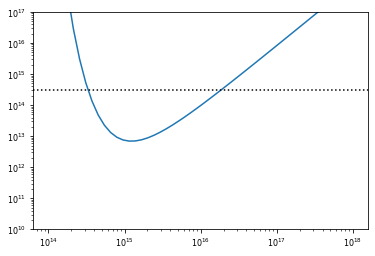

In [29]:
e_range = np.logspace(14, 18, 50)
depths = [optical_depth(x, 10**4.7).to("cm").value for x in e_range]
plt.plot(e_range, depths, label="UV")
plt.yscale("log")
plt.xscale("log")
plt.axhline(10.**14.5, linestyle=":", color="k")
plt.ylim((10**10, 10.**17.))

In [30]:
tde_budget = (const.M_sun * const.c**2).to("erg")
print(f"TDE energy budget {tde_budget:.2g}")

TDE energy budget 1.8e+54 erg


In [31]:
-7.5/18

-0.4166666666666667

In [32]:
5. ** 2.5


55.90169943749474

In [33]:
0.1 ** -((3*(3.5))/(13 + 5))

3.831186849557288

In [34]:
10/18

0.5555555555555556

In [35]:
22-(11*2.5)


-5.5

In [36]:
13 + 2 * 2.5

18.0

In [37]:
fermi_ul = 2 * 10**-12. * u.erg /u.cm**2 / u.s
print(f"Fermi UL {fermi_ul}")
print(f"Fermi UL {(0.5 * u.year * fermi_ul / (flux_conversion/u.cm**2)).to('erg')}")

Fermi UL 2e-12 erg / (cm2 s)
Fermi UL 2.0912530601677855e+50 erg
